In [6]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b5")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)


/home/yang.ming/miniconda3/envs/detr-playground/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_fuse.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.classifier.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.0.proj

In [2]:
example_image_url = "https://cdn-media.huggingface.co/Inference-API/Sample-results-on-the-Cityscapes-dataset-The-above-images-show-how-our-method-can-handle.png"
example_image = Image.open(requests.get(example_image_url, stream=True).raw)

In [3]:
import numpy as np
cityscapes_labels = [
    "road", "sidewalk", "building", "wall", "fence", 
    "pole", "traffic light", "traffic sign", "vegetation", "terrain",
    "sky", "person", "rider", "car", "truck", 
    "bus", "train", "motorcycle", "bicycle"
]
colors = np.random.randint(0, 255, size=(len(cityscapes_labels), 3), dtype=np.uint8)

In [4]:
import torch
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# image = example_image
image = Image.open("./datasets/Das3300161.jpg")
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)


# Overlay the mask on the original image
# Convert original image to numpy array and normalize it
image_np = np.array(image) / 255.0

# Apply softmax and argmax to get the most likely class for each pixel
probabilities = torch.nn.functional.softmax(logits, dim=1)
mask = torch.argmax(probabilities, dim=1)

# Resize mask to the size of the original image
mask = F.resize(mask.unsqueeze(1), size=image_np.shape[:2], interpolation=F.InterpolationMode.NEAREST).squeeze()

# Convert mask to numpy array for visualization
mask_np = mask.detach().cpu().numpy()

# Create an RGB image for each class (you might need to customize this part based on the number of classes and desired colors)
# random 14 colors : np.array([[0, 0, 0], ...]) for each class

seg_image = colors[mask_np]

# Overlay (this can be adjusted to change the transparency or the way of overlaying)
combined = 0.7 * image_np + 0.001 * seg_image

# Create a subplot: 1 row, 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axs[0].imshow(image_np)
axs[0].set_title('Original Image')
axs[0].axis('off')

# Segmentation mask
axs[1].imshow(seg_image)
axs[1].set_title('Segmentation Mask')
axs[1].axis('off')

# Combined image
axs[2].imshow(combined)
axs[2].set_title('Overlay Image')
axs[2].axis('off')

# filter label in output include in cityscapes_labels
unique_labels = np.unique(mask_np)

# Add the legend to the last subplot, convert colors to 0-1
patches = [mpatches.Patch(color=colors[i]/255.0, label=cityscapes_labels[i]) for i in range(len(cityscapes_labels)) if i in unique_labels]
axs[2].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


# Display the subplot
plt.tight_layout()
plt.show()

IndexError: index 607 is out of bounds for axis 0 with size 19

In [31]:
import json
import os

datasets_dir = "/Users/famer.me/Repository/crack-in-asphalt/2023-12-04/Origin/1"

labels = [
	file for file in os.listdir(datasets_dir) if file.endswith(".json")
]

images = [
	file[0:-5] + ".jpg" for file in labels
]

list(zip(labels, images))

labels_json = [
	json.load(open(os.path.join(datasets_dir, label), "r")) for label in labels
]

set([
	shape["label"]
	for label_json in labels_json
	for shape in label_json["shapes"]
])

{'building', 'car', 'crack', 'dog', 'litter', 'pavement', 'truck', 'tyer'}

In [33]:
labels_json[0].keys()

dict_keys(['version', 'flags', 'shapes', 'imagePath', 'imageData', 'imageHeight', 'imageWidth'])

In [1]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
processor = SegformerImageProcessor.from_pretrained('mingyang91/segformer-for-surveillance')
model = SegformerForSemanticSegmentation.from_pretrained("mingyang91/segformer-for-surveillance").to('mps')


In [2]:
from segformer_trainer import downsample_image_pil, polygons_to_mask, split_image_into_tiles, split_mask_into_tiles
import os
from PIL import Image
import numpy as np
import json

basedir = 'datasets/segformer/val'
test = 'Das1100051.json'
scale_factor = 4.0

ann_path = os.path.join(basedir, test)
img_path = os.path.join(basedir, test.replace('.json', '.jpg'))

# Load image
image = Image.open(img_path).convert("RGB")
image = downsample_image_pil(image, scale_factor=scale_factor)
image = np.array(image)

# Load annotation and create mask
with open(ann_path) as f:
    anns = json.load(f)
for shape in anns['shapes']:
    if shape['shape_type'] == 'polygon':
        shape['points'] = [[int(p[0] / scale_factor), int(p[1] / scale_factor)] for p in shape['points']]
mask = polygons_to_mask(image.shape[:2], anns['shapes'])

tiles = split_image_into_tiles(image)

# Optionally split the mask here in the same way if training
masks = split_mask_into_tiles(mask)

In [3]:
import torch

all_image_tiles = [processor(images=item, return_tensors="pt")['pixel_values'].squeeze() for item in tiles]
all_mask_tiles = [torch.as_tensor(item, dtype=torch.long) for item in masks]

# Stack the selected tensors to create batches
images_stacked = torch.stack(all_image_tiles).to('mps')
masks_stacked = torch.stack(all_mask_tiles).to('mps')


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='mps:0')

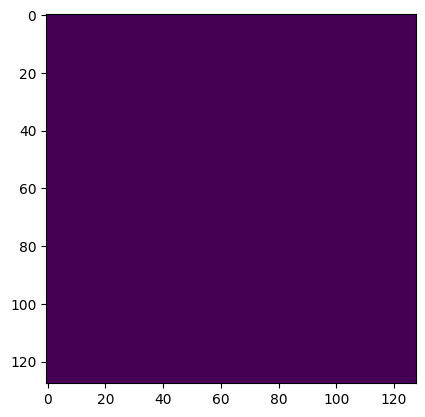

In [5]:
import matplotlib.pyplot as plt
from segformer_trainer import id2label
for i in range(len(images_stacked)):
	outputs = model(pixel_values=images_stacked[i].unsqueeze(0), labels=masks_stacked[i].unsqueeze(0))
	logits = outputs.logits
	probabilities = torch.nn.functional.softmax(logits, dim=1)
	mask = torch.argmax(probabilities, dim=1)
	mask = mask.cpu().numpy()
	plt.imshow(mask.squeeze())